In [1]:
import pyspark
from pyspark import SparkContext, SparkConf
import json
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# 读取筛选过的business
business_path = 'selected_data/business.json'
user_path = 'selected_data/user.json'

df_business = (pd.read_json(business_path)).T

In [3]:
# 分析有哪些service
services = df_business['attributes']
services_dict = {}
for item in services:
    try:
        for key in item.keys():
            if key not in services_dict.keys():
                services_dict[key] = [item[key]]
            else:
                if item[key] not in services_dict[key]:
                    services_dict[key].append(item[key])
    except:
        pass
services_dict

{'RestaurantsAttire': ["'casual'",
  "u'casual'",
  "'dressy'",
  "u'dressy'",
  "u'formal'",
  "'formal'",
  'None'],
 'RestaurantsGoodForGroups': ['False', 'True'],
 'BusinessAcceptsCreditCards': ['True', 'False', 'None'],
 'OutdoorSeating': ['True', 'False', 'None'],
 'GoodForKids': ['True', 'False'],
 'Alcohol': ["u'none'",
  "u'full_bar'",
  "u'beer_and_wine'",
  "'full_bar'",
  "'beer_and_wine'",
  "'none'",
  'None'],
 'BusinessParking': ["{'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet': False}",
  "{'garage': True, 'street': False, 'validated': True, 'lot': False, 'valet': True}",
  "{'garage': True, 'street': False, 'validated': False, 'lot': False, 'valet': False}",
  "{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}",
  "{'garage': None, 'street': True, 'validated': None, 'lot': False, 'valet': False}",
  "{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",
  "{u'valet': False, 

In [4]:
parking_dict = {}
for item in services_dict['BusinessParking']:
    tmp = item.replace('{', '').replace('}', '').replace('\'', '').replace(' ', '').split(',')
    for i in tmp:
        new_tmp = i.split(':')
        try:
            if new_tmp[0] not in parking_dict.keys():
                parking_dict[new_tmp[0]] = [new_tmp[1]]
            else:
                if new_tmp[1] not in parking_dict[new_tmp[0]]:
                    parking_dict[new_tmp[0]].append(new_tmp[1])
        except:
            pass
parking_dict

{'garage': ['False', 'True', 'None'],
 'street': ['False', 'True', 'None'],
 'validated': ['False', 'True', 'None'],
 'lot': ['False', 'True', 'None'],
 'valet': ['False', 'True'],
 'uvalet': ['False', 'True'],
 'ugarage': ['False', 'True', 'None'],
 'ustreet': ['None', 'False', 'True'],
 'ulot': ['None', 'True', 'False'],
 'uvalidated': ['None', 'False', 'True']}

In [5]:
music_dict = {}
for item in services_dict['Music']:
    tmp = item.replace('{', '').replace('}', '').replace('\'', '').replace(' ', '').split(',')
    for i in tmp:
        new_tmp = i.split(':')
        try:
            if new_tmp[0] not in music_dict.keys():
                music_dict[new_tmp[0]] = [new_tmp[1]]
            else:
                if new_tmp[1] not in music_dict[new_tmp[0]]:
                    music_dict[new_tmp[0]].append(new_tmp[1])
        except:
            pass
music_dict

{'dj': ['False', 'True', 'None'],
 'background_music': ['False', 'True'],
 'no_music': ['False'],
 'jukebox': ['False', 'None', 'True'],
 'live': ['False', 'True', 'None'],
 'video': ['False'],
 'karaoke': ['False', 'True', 'None'],
 'udj': ['False', 'None', 'True'],
 'ulive': ['None', 'False', 'True'],
 'ujukebox': ['False', 'None', 'True'],
 'uvideo': ['False'],
 'ubackground_music': ['False'],
 'ukaraoke': ['None', 'False', 'True'],
 'uno_music': ['False']}

### 我们感兴趣的特色服务
RestaurantsGoodForGroups: True / Not True

OutdoorSeating: True / not True

GoodForKids: True / not True

DogsAllowed: True / not True

RestaurantsDeliver: True / not True

RestaurantsTakeOut: True / not True

DriveThru: True / not True

HappyHour: True / not True

WheelchairAccessible: True / not True

BikeParking: True / not True

BYOB: True / not True

Corkage: True / not True

AcceptsInsurance：True / not True

Open24Hours: True / False

Smoking: u'outdoor', u'yes' / otherwise

NoiseLevel: "u'average'", "u'loud'", "'average'", "u'very_loud'", "u'quiet'", "'quiet'", "'loud'", "'very_loud'", 'None'

WiFi: "u'no'", "u'free'", "'free'", "u'paid'", "'no'", "'paid'", 'None'

Alcohol: "u'none'", "u'full_bar'", "u'beer_and_wine'", "'full_bar'", "'beer_and_wine'", "'none'", 'None'

BusinessParking: ???


In [6]:
# 得到service的matrix

# one-hot encoding
ratings = np.array(list(df_business['stars']))
services_matrix = np.zeros(27*8209).reshape(8209, 27)
# 0th-13th
service_name = ['RestaurantsGoodForGroups', 'OutdoorSeating', 'GoodForKids', 'DogsAllowed', 'RestaurantsDelivery',
                'RestaurantsTakeOut',  'DriveThru', 'HappyHour', 'WheelchairAccessible', 'BikeParking', 
                'BYOB', 'Corkage', 'AcceptsInsurance', 'Open24Hours']
# 14th-32th
# 'Smoing_yes', 'Smoking_outdoor', (14-15)
# 'Noise_average', 'Noise_loud', 'Noise_very_loud', 'Noise_quiet', (16-19)
# 'WIFI_free', 'WIFI_paid', (20-21)
# 'Park_garage', 'Park_street', 'Park_validated', 'Park_lot', 'Park_valet', (22-26)
for i in range(8209):
    # print(services[i])ve
    for j in range(14):
        try:
            if services[i][service_name[j]] == 'True':
                services_matrix[i][j] = 1
        except:
            pass
    try:
        if services[i]['Smoking'] == 'u\'yes\'':
            services_matrix[i][14] = 1
        elif services[i]['Smoking'] == 'u\'outdoor\'':
            services_matrix[i][15] = 1
    except:
        pass
    try:
        if services[i]['NoiseLevel'] == 'u\'average\'' or 'average':
            services_matrix[i][16] = 1
        elif services[i]['NoiseLevel'] == 'u\'loud\'' or 'loud':
            services_matrix[i][17] = 1
        elif services[i]['NoiseLevel'] == 'u\'very_loud\'' or 'very_loud':
            services_matrix[i][18] = 1
        elif services[i]['NoiseLevel'] == 'quiet':
            services_matrix[i][19] = 1
        else:
            services_matrix[i][16] = 1
    except:
        pass
    try:
        if services[i]['WiFi'] == 'u\'free\'' or 'free':
            services_matrix[i][20] = 1
        elif services[i]['WiFi'] == 'u\'paid\'' or 'paid':
            services_matrix[i][21] = 1
    except:
        pass
    
    try:
        park_ser = {}
        tmp = services[i]['BusinessParking'].replace('{', '').replace('}', '').replace('\'', '').replace(' ', '').split(',')
        for t in tmp:
            new_tmp = t.split(':')
            try:
                park_ser[new_tmp[0]] = new_tmp[1]
            except:
                pass
    except:
        pass
    try:
        if park_ser['garage'] == 'True':
            services_matrix[i][22] = 1
    except:
        pass  
    try:
        if park_ser['ugarage'] == 'True': 
            services_matrix[i][22] = 1
    except:
        pass  
    try:
        if park_ser['street'] == 'True':
            services_matrix[i][23] = 1
    except:
        pass
    try:
        if park_ser['ustreet'] == 'True':
            services_matrix[i][23] = 1
    except:
        pass
    try:
        if park_ser['validated'] == 'True':
            services_matrix[i][24] = 1
    except:
        pass
    try:
        if park_ser['uvalidated'] == 'True':
            services_matrix[i][24] = 1
    except:
        pass
    try:
        if park_ser['lot'] == 'True':
            services_matrix[i][25] = 1
    except:
        pass
    try:
        if park_ser['ulot'] == 'True':
            services_matrix[i][25] = 1
    except:
        pass
    try:
        if park_ser['valet'] == 'True':
            services_matrix[i][26] = 1
    except:
        pass
    try:
        if park_ser['uvalet'] == 'True':
            services_matrix[i][26] = 1
    except:
        pass


In [7]:
# 得到service的dataframe
service_df = pd.DataFrame(services_matrix)
col_name = {0:'RestaurantsGoodForGroups', 1:'OutdoorSeating', 2:'GoodForKids', 3:'DogsAllowed', 
            4:'RestaurantsDelivery', 5: 'RestaurantsTakeOut', 6:'DriveThru', 7:'HappyHour', 8:'WheelchairAccessible', 
            9:'BikeParking', 10:'BYOB', 11:'Corkage', 12:'AcceptsInsurance', 13:'Open24Hours', 
            14:'Smoking_yes', 15:'Smoking_outdoor', 
            16:'Noise_average', 17:'Noise_loud', 18:'Noise_very_loud', 19:'Noise_quiet', 
            20:'WIFI_free', 21:'WIFI_paid', 
            22:'Park_garage', 23:'Park_street', 24:'Park_validated', 25:'Park_lot', 26:'Park_valet'}
service_df.rename(columns=col_name, inplace=True)
service_df

,RestaurantsGoodForGroups,OutdoorSeating,GoodForKids,DogsAllowed,RestaurantsDelivery,RestaurantsTakeOut,DriveThru,HappyHour,WheelchairAccessible,BikeParking,...,Noise_loud,Noise_very_loud,Noise_quiet,WIFI_free,WIFI_paid,Park_garage,Park_street,Park_validated,Park_lot,Park_valet
0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8204,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
8205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8206,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
8207,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


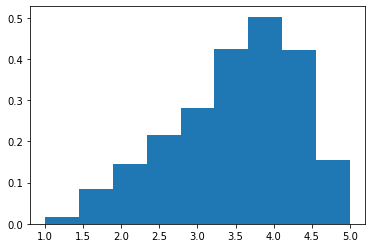

In [8]:
# 所有店铺的ratings分布
plt.hist(ratings, bins=9, density=True)
plt.savefig('figs/rating_distribution.png')

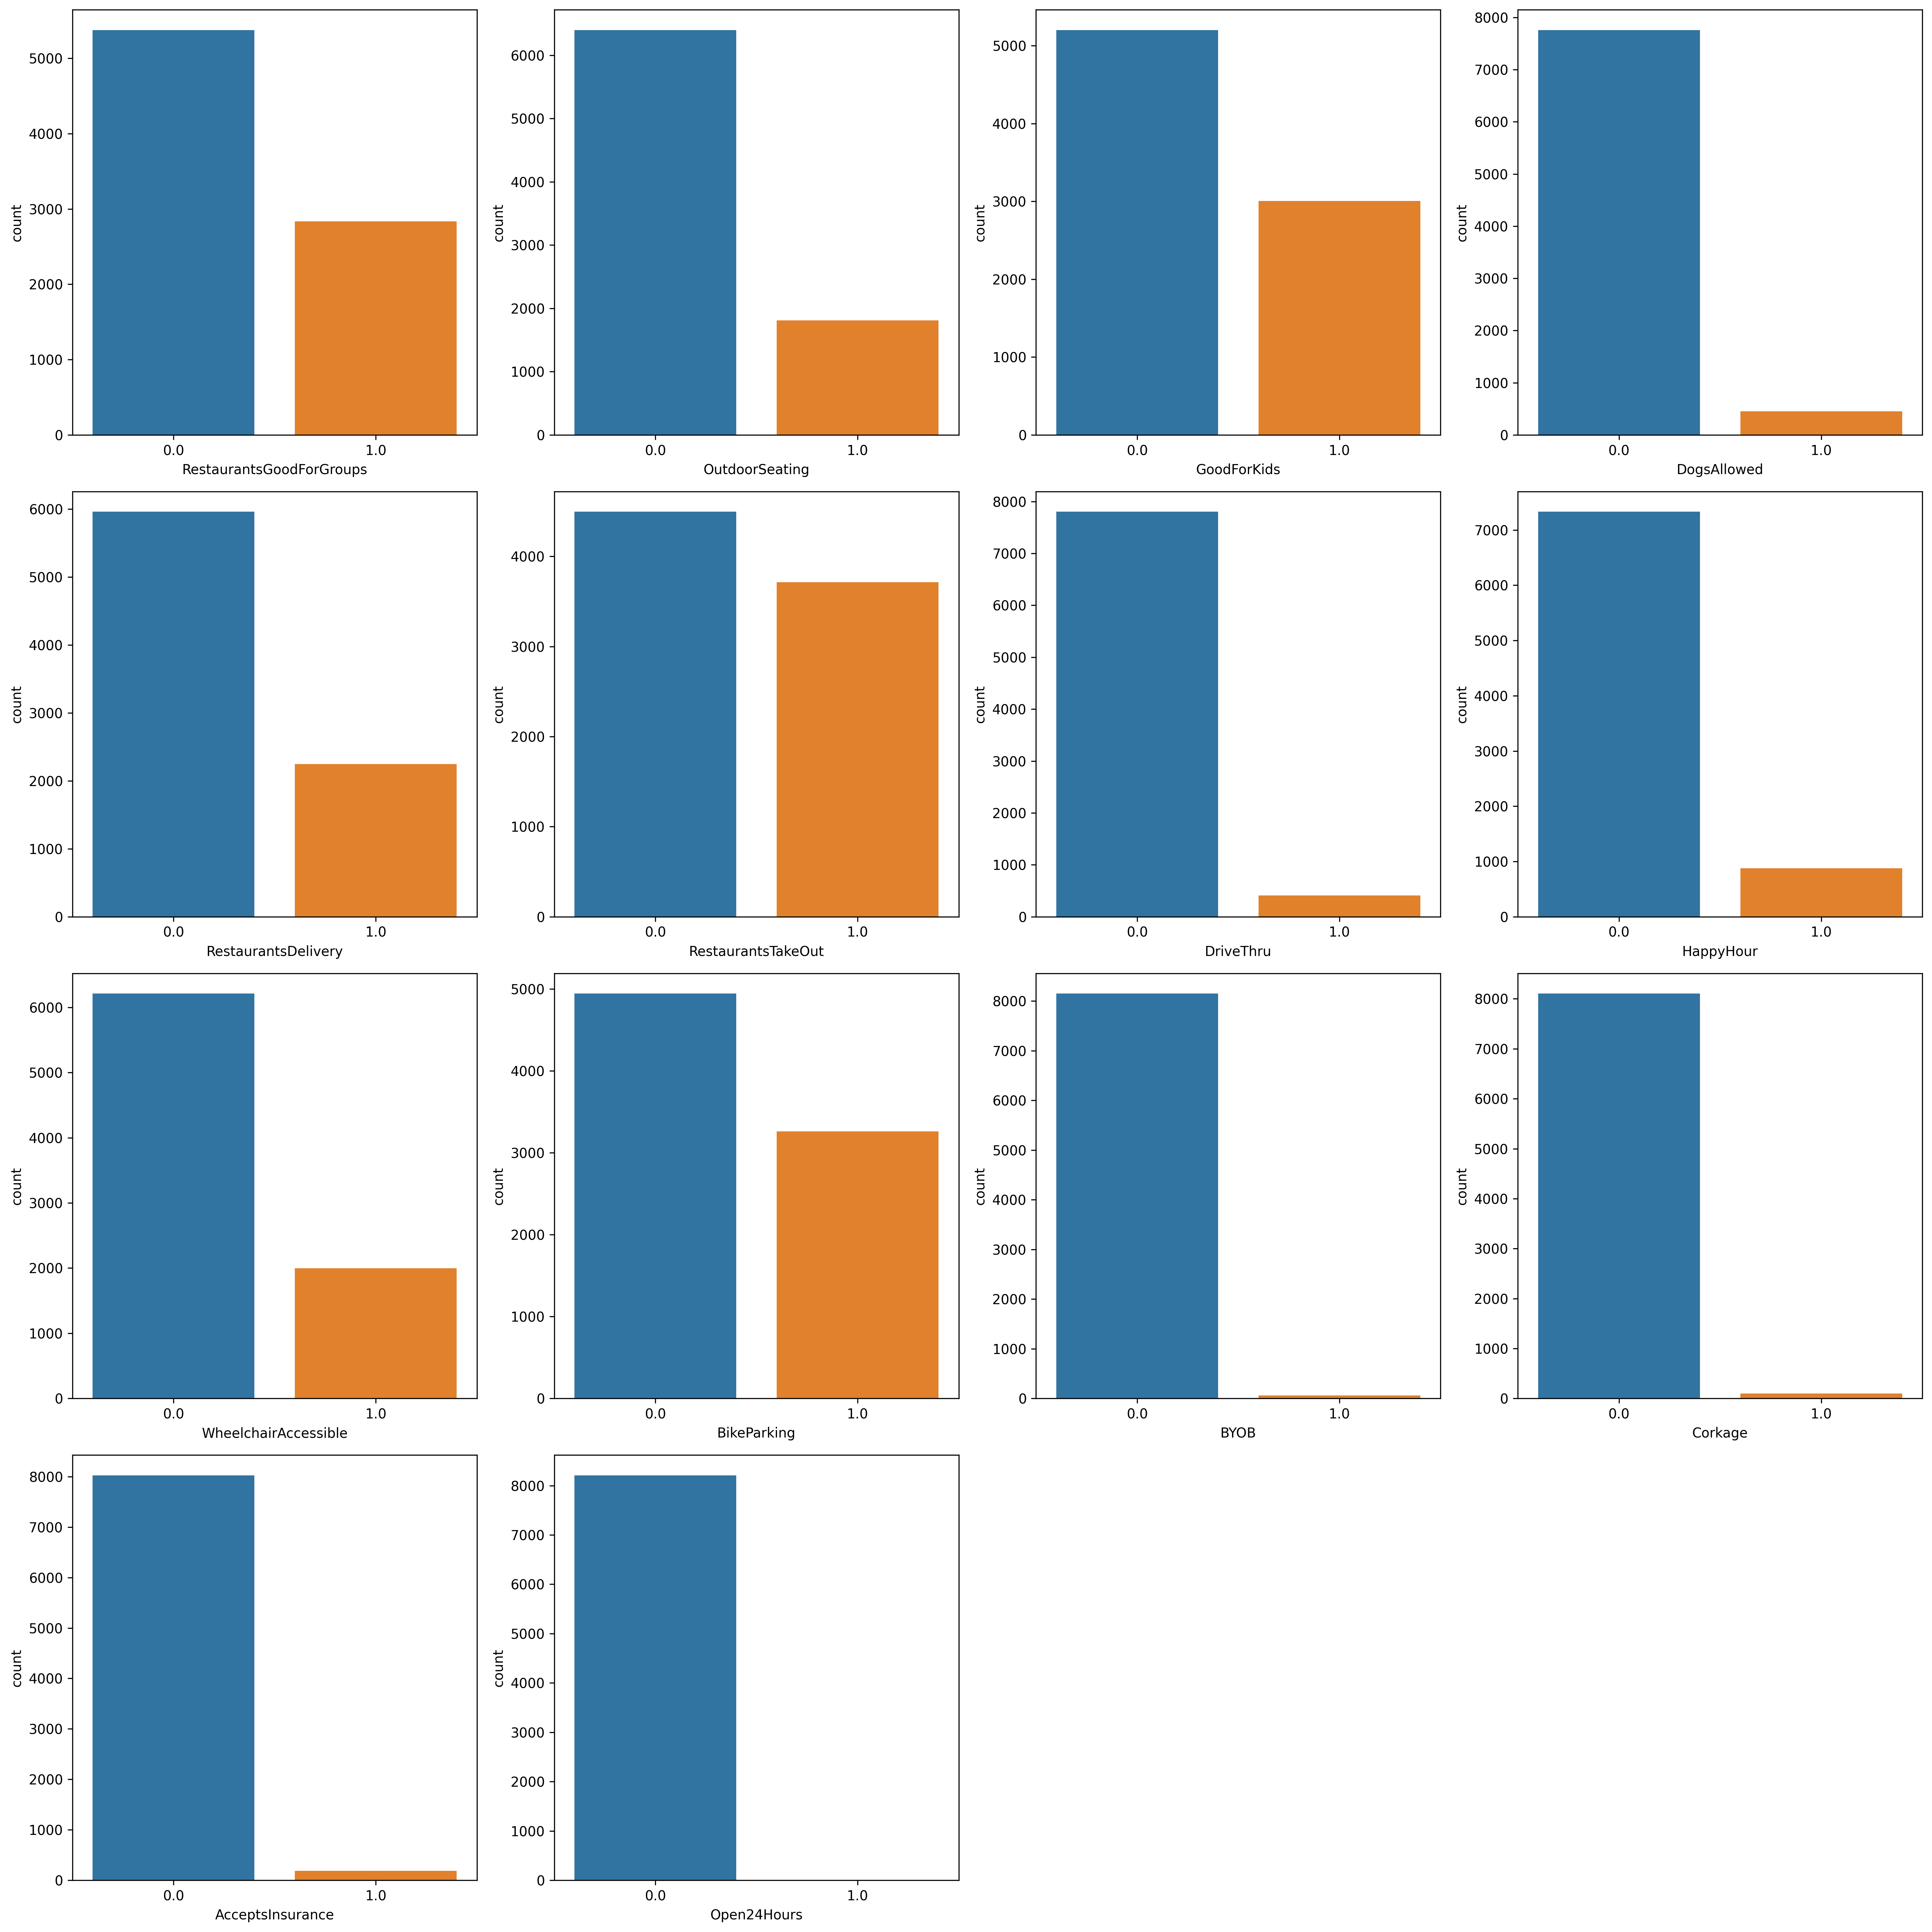

In [10]:
# 有多少商家提供这些service（前14个）
plt.figure(dpi=300,figsize=(20,20))
plt.subplot(4,4,1)
sns.countplot(x = 'RestaurantsGoodForGroups', data = service_df)
plt.subplot(4,4,2)
sns.countplot(x = 'OutdoorSeating', data = service_df)
plt.subplot(4,4,3)
sns.countplot(x = 'GoodForKids', data = service_df)
plt.subplot(4,4,4)
sns.countplot(x = 'DogsAllowed', data = service_df)
plt.subplot(4,4,5)
sns.countplot(x = 'RestaurantsDelivery', data = service_df)
plt.subplot(4,4,6)
sns.countplot(x = 'RestaurantsTakeOut', data = service_df)
plt.subplot(4,4,7)
sns.countplot(x = 'DriveThru', data = service_df)
plt.subplot(4,4,8)
sns.countplot(x = 'HappyHour', data = service_df)
plt.subplot(4,4,9)
sns.countplot(x = 'WheelchairAccessible', data = service_df)
plt.subplot(4,4,10)
sns.countplot(x = 'BikeParking', data = service_df)
plt.subplot(4,4,11)
sns.countplot(x = 'BYOB', data = service_df)
plt.subplot(4,4,12)
sns.countplot(x = 'Corkage', data = service_df)
plt.subplot(4,4,13)
sns.countplot(x = 'AcceptsInsurance', data = service_df)
plt.subplot(4,4,14)
sns.countplot(x = 'Open24Hours', data = service_df)
plt.tight_layout()
plt.savefig('figs/provide_ratio.png')
plt.show()

In [11]:
# for saving figs
plt.subplot(1,2,1)
sns.countplot(x = 'RestaurantsGoodForGroups', data = service_df)
plt.subplot(1,2,2)
sns.countplot(x = 'OutdoorSeating', data = service_df)
plt.tight_layout()
plt.savefig('figs/provide_ratio1.png')
plt.clf()

plt.subplot(1,2,1)
sns.countplot(x = 'GoodForKids', data = service_df)
plt.subplot(1,2,2)
sns.countplot(x = 'DogsAllowed', data = service_df)
plt.tight_layout()
plt.savefig('figs/provide_ratio2.png')
plt.clf()

plt.subplot(1,2,1)
sns.countplot(x = 'RestaurantsDelivery', data = service_df)
plt.subplot(1,2,2)
sns.countplot(x = 'RestaurantsTakeOut', data = service_df)
plt.tight_layout()
plt.savefig('figs/provide_ratio3.png')
plt.clf()

plt.subplot(1,2,1)
sns.countplot(x = 'DriveThru', data = service_df)
plt.subplot(1,2,2)
sns.countplot(x = 'HappyHour', data = service_df)
plt.tight_layout()
plt.savefig('figs/provide_ratio4.png')
plt.clf()

plt.subplot(1,2,1)
sns.countplot(x = 'WheelchairAccessible', data = service_df)
plt.subplot(1,2,2)
sns.countplot(x = 'BikeParking', data = service_df)
plt.tight_layout()
plt.savefig('figs/provide_ratio5.png')
plt.clf()

plt.subplot(1,2,1)
sns.countplot(x = 'BYOB', data = service_df)
plt.subplot(1,2,2)
sns.countplot(x = 'Corkage', data = service_df)
plt.tight_layout()
plt.savefig('figs/provide_ratio6.png')
plt.clf()

plt.subplot(1,2,1)
sns.countplot(x = 'AcceptsInsurance', data = service_df)
plt.subplot(1,2,2)
sns.countplot(x = 'Open24Hours', data = service_df)
plt.tight_layout()
plt.savefig('figs/provide_ratio7.png')
plt.clf()

plt.subplot(1,2,1)
service_df['Smoking'] = service_df['Smoking_yes'] + service_df['Smoking_outdoor']*2
for i in range(8209):
    if service_df.loc[i, 'Smoking_yes'] == 1 or service_df.loc[i, 'Smoking_outdoor'] == 1:
        service_df.loc[i, 'Smoking'] = 1
    else:
        service_df.loc[i, 'Smoking'] = 0
sns.countplot(x = 'Smoking', data = service_df)
plt.subplot(1,2,2)
service_df['Noise'] = service_df['Noise_quiet'] + service_df['Noise_average']*2 + service_df['Noise_loud']*3 + service_df['Noise_very_loud']*4
sns.countplot(x = 'Noise', data = service_df)
plt.tight_layout()
plt.savefig('figs/provide_ratio8.png')
plt.clf()

plt.subplot(1,2,1)
service_df['WIFI'] = service_df['WIFI_free'] + service_df['WIFI_paid']*2
sns.countplot(x = 'WIFI', data = service_df)
plt.subplot(1,2,2)
service_df['Park'] = service_df['Park_garage']
for i in range(8209):
    #print(service_df.loc[i, 'Park_garage'])
    if service_df.loc[i, 'Park_garage'] == 1 or service_df.loc[i, 'Park_street'] == 1 or service_df.loc[i, 'Park_validated'] == 1 or service_df.loc[i, 'Park_valet'] == 1 or service_df.loc[i, 'Park_lot'] == 1:
        service_df.loc[i, 'Park'] = 1
    else:
        service_df.loc[i, 'Park'] = 0
sns.countplot(x = 'Park', data = service_df)
plt.tight_layout()
plt.savefig('figs/provide_ratio9.png')
plt.clf()
#plt.tight_layout()
#plt.savefig('figs/provide_ratio.png')

<Figure size 432x288 with 0 Axes>

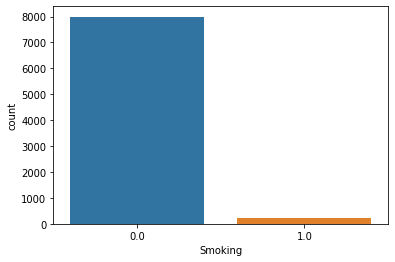

In [11]:
# smoking
service_df['Smoking'] = service_df['Smoking_yes'] + service_df['Smoking_outdoor']*2
for i in range(8209):
    if service_df.loc[i, 'Smoking_yes'] == 1 or service_df.loc[i, 'Smoking_outdoor'] == 1:
        service_df.loc[i, 'Smoking'] = 1
    else:
        service_df.loc[i, 'Smoking'] = 0
sns.countplot(x = 'Smoking', data = service_df)
plt.savefig('figs/smoke_ratio.png')

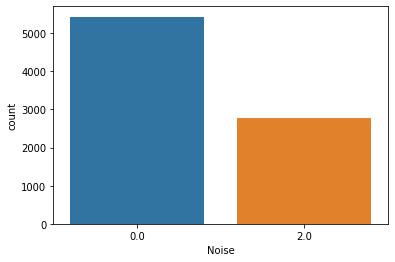

In [12]:
# noise
service_df['Noise'] = service_df['Noise_quiet'] + service_df['Noise_average']*2 + service_df['Noise_loud']*3 + service_df['Noise_very_loud']*4
sns.countplot(x = 'Noise', data = service_df)
plt.savefig('figs/noise_ratio.png')

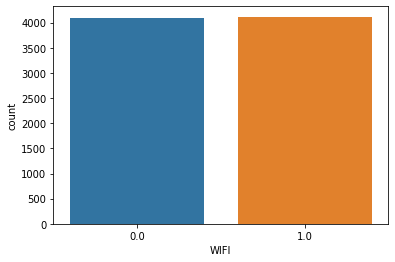

In [13]:
# WIFI
service_df['WIFI'] = service_df['WIFI_free'] + service_df['WIFI_paid']*2
sns.countplot(x = 'WIFI', data = service_df)
plt.savefig('figs/WIFI_ratio.png')

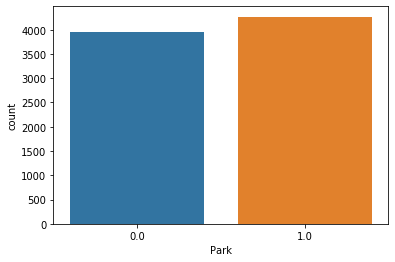

In [14]:
# Park
service_df['Park'] = service_df['Park_garage']
for i in range(8209):
    #print(service_df.loc[i, 'Park_garage'])
    if service_df.loc[i, 'Park_garage'] == 1 or service_df.loc[i, 'Park_street'] == 1 or service_df.loc[i, 'Park_validated'] == 1 or service_df.loc[i, 'Park_valet'] == 1 or service_df.loc[i, 'Park_lot'] == 1:
        service_df.loc[i, 'Park'] = 1
    else:
        service_df.loc[i, 'Park'] = 0
sns.countplot(x = 'Park', data = service_df)
plt.savefig('figs/park_ratio.png')

### 保留的service（去除了很少饭店会有的service）
RestaurantsGoodForGroups

OutdoorSeating 

GoodForKids

DogsAllowed

RestaurantsDelivery

RestaurantsTakeOut

HappyHour

WheelchairAccessible

BikeParking

Smoking

WIFI

Park

In [12]:
col_names = ['RestaurantsGoodForGroups', 'OutdoorSeating', 'GoodForKids', 'DogsAllowed', 'RestaurantsDelivery',
             'RestaurantsTakeOut', 'HappyHour', 'WheelchairAccessible', 'BikeParking', 'Smoking', 'WIFI', 'Park']
sel_service_df = pd.DataFrame(service_df,columns=col_names)
sel_service_df['Ratings'] = list(df_business['stars'])
sel_service_df['business_id'] = list(df_business.index)
sel_service_df

,RestaurantsGoodForGroups,OutdoorSeating,GoodForKids,DogsAllowed,RestaurantsDelivery,RestaurantsTakeOut,HappyHour,WheelchairAccessible,BikeParking,Smoking,WIFI,Park,Ratings,business_id
0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.5,bBDDEgkFA1Otx9Lfe7BZUQ
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,4.0,tMkwHmWFUEXrC9ZduonpTg
2,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,3.5,lk9IwjZXqUMqqOhM774DtQ
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.5,B2qqjCl_BNNnXvWWfpFiLA
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,4.5,oaboaRBUgGjbo2kfUIKDLQ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8204,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,3.5,35JPTJ69zVoTGuk6TBX5qA
8205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.5,Jv7_p4V9KG7Ar_GEXDenng
8206,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,3.5,9iCum5W48TqNVDTZCJUKjg
8207,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,4.5,i6r6IdA-P8eGAgqZTUrQ3Q


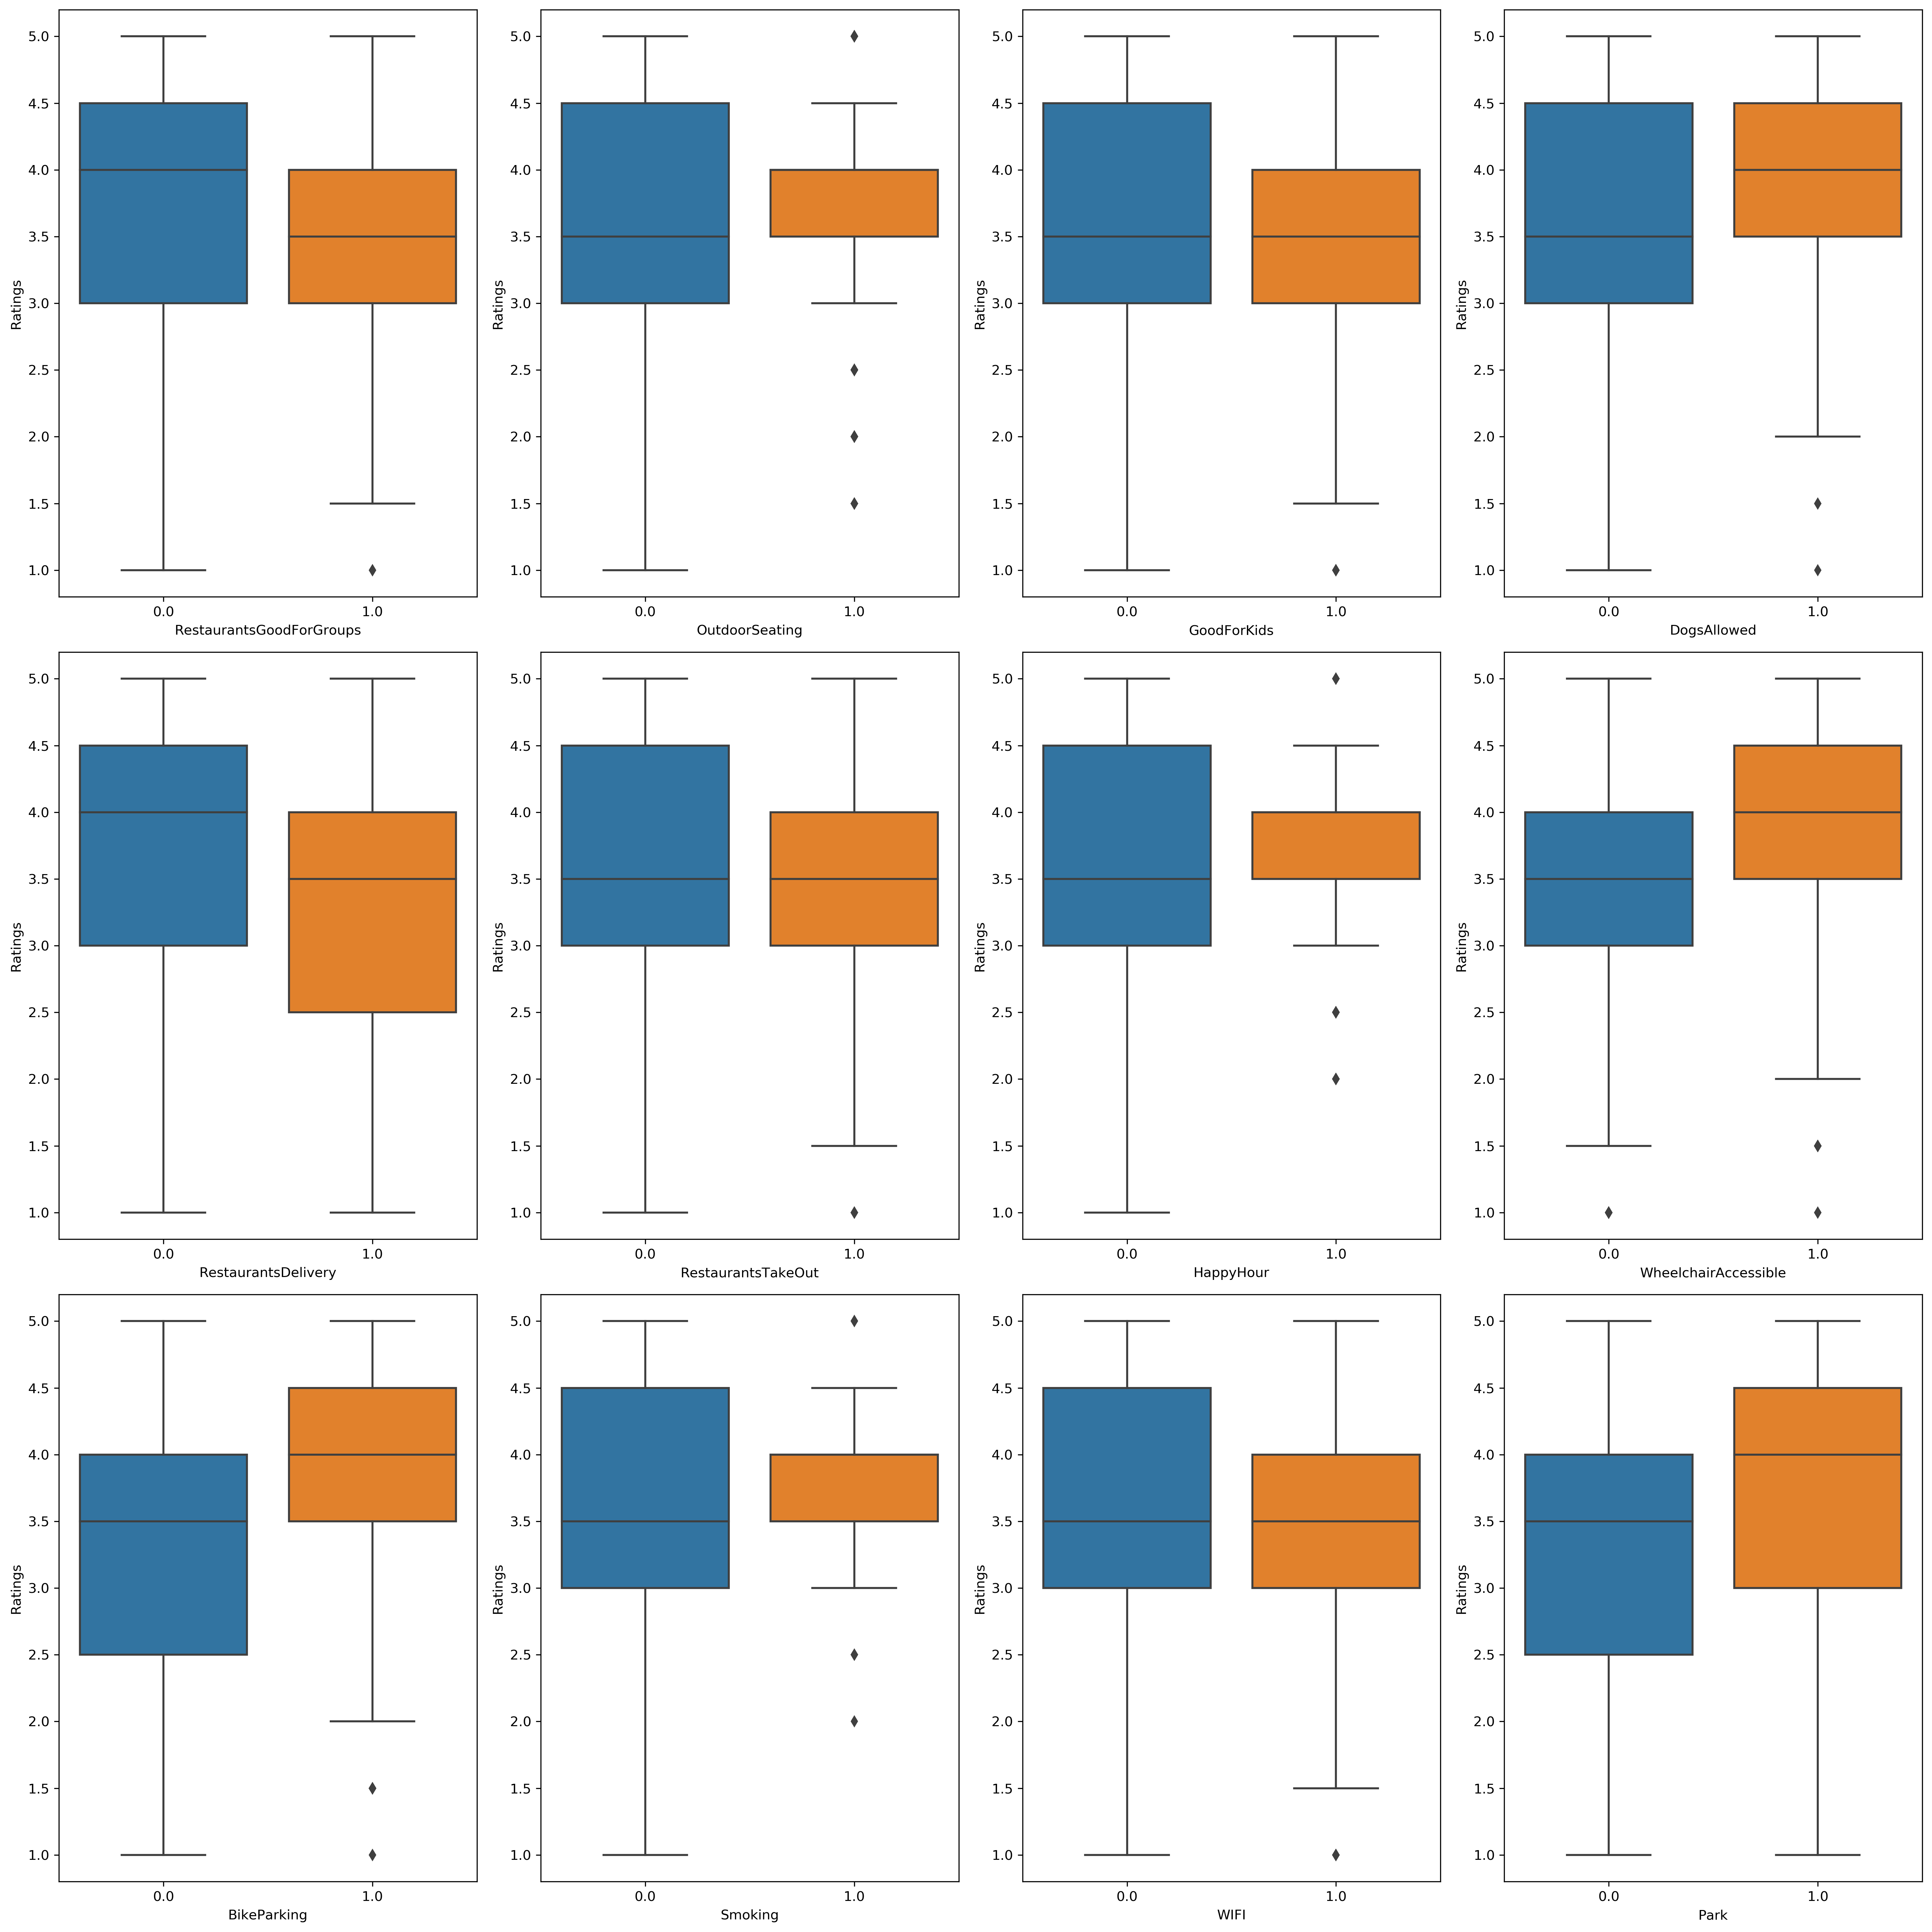

In [18]:
# 分析每项service与rating的关系
plt.figure(dpi=300,figsize=(20,20))
plt.subplot(3,4,1)
sns.boxplot(x='RestaurantsGoodForGroups', y='Ratings', data = sel_service_df)
plt.subplot(3,4,2)
sns.boxplot(x='OutdoorSeating', y='Ratings', data = sel_service_df)
plt.subplot(3,4,3)
sns.boxplot(x='GoodForKids', y='Ratings', data = sel_service_df)
plt.subplot(3,4,4)
sns.boxplot(x='DogsAllowed', y='Ratings', data = sel_service_df)
plt.subplot(3,4,5)
sns.boxplot(x='RestaurantsDelivery', y='Ratings', data = sel_service_df)
plt.subplot(3,4,6)
sns.boxplot(x='RestaurantsTakeOut', y='Ratings', data = sel_service_df)
plt.subplot(3,4,7)
sns.boxplot(x='HappyHour', y='Ratings', data = sel_service_df)
plt.subplot(3,4,8)
sns.boxplot(x='WheelchairAccessible', y='Ratings', data = sel_service_df)
plt.subplot(3,4,9)
sns.boxplot(x='BikeParking', y='Ratings', data = sel_service_df)
plt.subplot(3,4,10)
sns.boxplot(x='Smoking', y='Ratings', data = sel_service_df)
plt.subplot(3,4,11)
sns.boxplot(x='WIFI', y='Ratings', data = sel_service_df)
plt.subplot(3,4,12)
sns.boxplot(x='Park', y='Ratings', data = sel_service_df)
plt.tight_layout()
plt.savefig('figs/ser_rate_relation.png')
plt.show()

In [13]:
# for saving figs
plt.subplot(1,2,1)
sns.boxplot(x='RestaurantsGoodForGroups', y='Ratings', data = sel_service_df)
plt.subplot(1,2,2)
sns.boxplot(x='OutdoorSeating', y='Ratings', data = sel_service_df)
plt.tight_layout()
plt.savefig('figs/ser_rate_relation1.png')
plt.clf()

plt.subplot(1,2,1)
sns.boxplot(x='GoodForKids', y='Ratings', data = sel_service_df)
plt.subplot(1,2,2)
sns.boxplot(x='DogsAllowed', y='Ratings', data = sel_service_df)
plt.tight_layout()
plt.savefig('figs/ser_rate_relation2.png')
plt.clf()

plt.subplot(1,2,1)
sns.boxplot(x='RestaurantsDelivery', y='Ratings', data = sel_service_df)
plt.subplot(1,2,2)
sns.boxplot(x='RestaurantsTakeOut', y='Ratings', data = sel_service_df)
plt.tight_layout()
plt.savefig('figs/ser_rate_relation3.png')
plt.clf()

plt.subplot(1,2,1)
sns.boxplot(x='HappyHour', y='Ratings', data = sel_service_df)
plt.subplot(1,2,2)
sns.boxplot(x='WheelchairAccessible', y='Ratings', data = sel_service_df)
plt.tight_layout()
plt.savefig('figs/ser_rate_relation4.png')
plt.clf()

plt.subplot(1,2,1)
sns.boxplot(x='BikeParking', y='Ratings', data = sel_service_df)
plt.subplot(1,2,2)
sns.boxplot(x='Smoking', y='Ratings', data = sel_service_df)
plt.tight_layout()
plt.savefig('figs/ser_rate_relation5.png')
plt.clf()

plt.subplot(1,2,1)
sns.boxplot(x='WIFI', y='Ratings', data = sel_service_df)
plt.subplot(1,2,2)
sns.boxplot(x='Park', y='Ratings', data = sel_service_df)
plt.tight_layout()
plt.savefig('figs/ser_rate_relation6.png')
plt.clf()

<Figure size 432x288 with 0 Axes>

### 对ratings有影响的service
*RestaurantsGoodForGroups*: 有这项服务的rating反而低，明显（？？？）

OutdoorSeating: 有这项服务的rating略高，不明显

~~GoodForKids: 几乎无影响~~

**DogsAllowed**: 有这项服务的rating高，明显

*RestaurantsDelivery*: 有这项服务的rating反而低，明显（？？？）

~~RestaurantsTakeOut: 几乎无影响~~

HappyHour: 有这项服务的rating略高，不明显

**WheelchairAccessible**: 有这项服务的rating高，明显

**BikeParking**: 有这项服务的rating高，明显

Smoking: 有这项服务的rating略高，不明显

~~WIFI: 几乎无影响~~

**Park**: 有这项服务的rating高，明显

In [18]:
# 最终选择训练时所需的service，并保存
col_names = ['business_id','Ratings','RestaurantsGoodForGroups', 'OutdoorSeating', 'DogsAllowed', 'RestaurantsDelivery',
             'HappyHour', 'WheelchairAccessible', 'BikeParking', 'Smoking', 'Park']
final_service_df = pd.DataFrame(sel_service_df,columns=col_names)
final_service_df.to_csv('train_data/services.csv')
final_service_df

,business_id,Ratings,RestaurantsGoodForGroups,OutdoorSeating,DogsAllowed,RestaurantsDelivery,HappyHour,WheelchairAccessible,BikeParking,Smoking,Park
0,bBDDEgkFA1Otx9Lfe7BZUQ,1.5,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,tMkwHmWFUEXrC9ZduonpTg,4.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,lk9IwjZXqUMqqOhM774DtQ,3.5,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
3,B2qqjCl_BNNnXvWWfpFiLA,1.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,oaboaRBUgGjbo2kfUIKDLQ,4.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
8204,35JPTJ69zVoTGuk6TBX5qA,3.5,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
8205,Jv7_p4V9KG7Ar_GEXDenng,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8206,9iCum5W48TqNVDTZCJUKjg,3.5,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
8207,i6r6IdA-P8eGAgqZTUrQ3Q,4.5,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
